In [1]:
import os
print(os.getcwd())
rdir='/home/hyeryungson'
os.chdir(os.path.join(rdir, 'mucoco/notebooks'))
os.chdir(os.path.join(rdir, 'mucoco'))

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import DataCollatorWithPadding, AutoModelForSequenceClassification, AutoTokenizer, AutoConfig

/home/hyeryungson/mucoco


In [2]:
# set gpu (template code)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 0 to use

In [3]:
# set device type
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Which cpu/cuda?: {DEVICE}")
print(f"Which device?: {torch.cuda.current_device()}")

Which cpu/cuda?: cuda
Which device?: 0


In [5]:
# Define dataset
toxicity_data = load_dataset("csv", data_files="./notebooks/results/test_mucoco+add_preds2.csv")
# toxicity_data = load_dataset("json", data_files="./data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/train.jsonl")

# load trained model & tokenizer
# checkpoint='/home/hyeryungson/mucoco/models/models_balanced/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/checkpoint_best/pytorch_model.bin' # balanced
# model, tokenizer = define_model(checkpoint, output_attentions=True)

checkpoint = 'mohsenfayyaz/toxicity-classifier'

labels=[0,1]
config = AutoConfig.from_pretrained(checkpoint, num_labels=len(labels))
config.output_attentions = True ## set this option!
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_dataset=toxicity_data.map(tokenize_function, batched=True)

# remove unnecessary columns, rename columns
tokenized_dataset = tokenized_dataset.remove_columns(["text"]) # drop columns except input_id, labels, attention_mask
tokenized_dataset = tokenized_dataset.rename_column("toxicity", "labels")
tokenized_dataset.set_format("torch")

# select those samples that we want to debug (check attention scores of)
tokenized_dataset_subset = tokenized_dataset["train"].filter(lambda x: (x["labels"]==1.0))

# build data loader
batch_size = 32
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
subset_dataloader = DataLoader(
    dataset=tokenized_dataset_subset, shuffle=False, batch_size=batch_size, collate_fn=data_collator
)

Found cached dataset csv (/home/hyeryungson/.cache/huggingface/datasets/csv/default-f2c97d4747e75281/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/4505 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4505 [00:00<?, ? examples/s]

In [28]:
tokenizer.all_special_ids

[100, 102, 0, 101, 103]

In [29]:
tokenizer.convert_ids_to_tokens(tokenizer.all_special_ids)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [ ]:
def get_attention_per_token(cls_model, dataloader, layer_num=10, model_type="bert",
                            token_ids_to_skip=None,
                            device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')):

    layer_num=10
    cls_attns_soft_list = []
    input_id_list = []
    labels_list = []
    preds_list = []
    cls_model.eval()
    cls_model.to(device)
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()} # move training data to gpu
        with torch.no_grad():
            outputs = cls_model.forward(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
            )
        ############### main logic for looking at attentions for XAI : BEGIN ###############
        attentions = outputs["attentions"][layer_num]
        if model_type == "bert": # reference: LEWIS paper
            cls_attns = attentions.max(1)[0][1:, 0]  # [1:, 0] because we want to skip CLS token
        elif model_type == "gpt":
            cls_attns = attentions.max(1)[0][:, 0] # [:, ]
        print(cls_attns)
        cls_attns[cls_attns==0.0] = -float("inf")
        cls_attns_soft = cls_attns.softmax(-1)
        ############### main logic for looking at attentions for XAI : END ###############
        cls_attns_soft_list.append(cls_attns_soft)
        input_id_list.append(batch["input_ids"])
        labels_list.append(batch["labels"])
        preds_list.append(outputs["logits"].softmax(-1)[:,1])

    for batch_num in range(len(cls_attns_soft_list)):
        print("Batch: ", batch_num)
        for ix in range(len(cls_attns_soft_list[batch_num])):

            attn=cls_attns_soft_list[batch_num][ix][cls_attns_soft_list[batch_num][ix]!=0.0]
            attn=attn.cpu().unsqueeze(0).numpy()
            toks=tokenizer.convert_ids_to_tokens(input_id_list[batch_num][ix][torch.isin(input_id_list[batch_num][ix], torch.Tensor(token_ids_to_skip).to(device), invert=True)])
            print(toks)
            fig, ax = plt.subplots(figsize=(0.2 * len(toks), 0.5))
            # sns.heatmap(attn, cbar=False,vmin=0, vmax=1)
            sns.heatmap(attn, cbar=False, ax=ax)
            for _x in range(attn.shape[-1]):
                plt.text(_x, 0.8, toks[_x], size=8, color='gray', rotation=40)
            plot_title = f"{layer_num}th Layer Attn / Ground Truth: {labels_list[batch_num][ix]:.3f} / Pred: {preds_list[batch_num][ix]:.3f}"
            file_name = f"./notebooks/XAI/fig/layer{layer_num}_gt{labels_list[batch_num][ix]:.3f}_pred{preds_list[batch_num][ix]:.3f}_ix{ix+32*batch_num}.png"
            plt.title(plot_title)
            plt.savefig(file_name, bbox_inches="tight")
            plt.show()

Batch:  0
['i', 'always', 'said', 'i', 'was', 'waiting', 'until', 'i', 'could', 'do', 'this', 'in', 'the', 'summer', '.', 'crap', 'what', 'will', 'my', 'excuse', 'be', 'now', '?', '?', '.', '.', '.', '.', '.', '.']


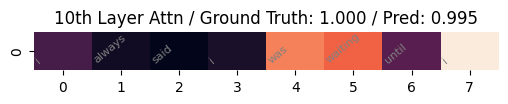

['in', 'a', 'word', ',', 'rubbish', '.']


IndexError: list index out of range

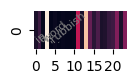

In [51]:
get_attention_per_token(model, subset_dataloader, token_ids_to_skip=[100, 102, 0, 101, 103])